In [1]:
import pandas as pd
import numpy as np

In [2]:
births_df = pd.read_csv(
    "../datasets/daily-total-female-births/daily-total-female-births.csv",
    header=0,
    index_col=0,
)

In [3]:
births_df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


Check Lists:

- **Assumption**: The amount to brithes is related to the amount of birth few days ago
- We can use random forest to predict the amount of birth given a few days of historical data
- Has missing value?
  No (series[series.isna()].count())
- Timeseries data interval?
  (1 day, since 1st element in head is Jan 1st, last element in tail is Dec 31st)
- Amount of columns?
  1 column (Births), the date will be ignored
- Amount of rows?
  365 (Not enough, one assumption is after certain amount of time, there may be 2nd child born, so the birth rate may have a pattern / season? for each 10 or 12 months)
- Data type
  int64
- Unit of feature
  amount of births in each day
- Any outliers?
  Yes, there is a Births value == 73, but fortime series, outliner cannot be simple ignored, How?
- Feature doesn't contains a lot of outliers
- Feature is not capped, distributed in a bell shape
- Residual type? What is residual type?

Plan:

1. Convert the time series to various supervised learnaing problems with to 1 10, 20 and 30 days sliding window width
2. For each series, split to train and test set, and cannot use random splitting, so the splitting function need to use write
3. For each series, train the random forest model with default setting and compare the result


In [4]:
# Reset index
births_reindexed = births_df.reset_index()['Births']

# Get the full time series array of birth data
births_ts_lst = births_reindexed.values

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class SeriesToSupervised(BaseEstimator, TransformerMixin):
    """
    Parameters
    ----------
    n_in: int, default 1
        Number of lag observations as input (X).

    n_out: int, default 1
        Number of observations as output (y).
    
    Attributes
    ----------
    features: nparray
        Extracted features based on the n_out
    labels: nparray
        Extracted lables based on the n_out
    """
    def __init__(self, n_in=1, n_out=1):
        self.n_in = n_in
        self.n_out = n_out
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = pd.DataFrame(X)

        tslsts = list()

        # input sequence (t-n, ... t-1)
        for i in range(self.n_in, 0, -1):
            tslsts.append(df.shift(i))

        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, self.n_out):
            tslsts.append(df.shift(-i))

        agg = pd.concat(tslsts, axis=1)

        agg.dropna(inplace=True)
        supervised = np.c_[agg.values]

        self.features = supervised[:, :-self.n_out]
        self.labels = supervised[:, -self.n_out:]
        
        return supervised
    
    def get_feature_label(self):
        return self.features, self.labels

In [37]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


class WalkForwardValidation:
    """
    Parameters
    ----------
    n_test: int, default 10
        Total steps walk forward to validate
    """

    def __init__(self, estimator, X, y, n_test=10):
        self.estimator = estimator
        self.X = X
        self.y = y
        self.n_test = n_test

        self.expected = y[-n_test:]
        self.predicted = list()

        self.trainX = X[:-n_test]
        self.trainy = y[:-n_test]

        self.testX = X[-n_test:]

    def validate(self):

        for i_test in range(self.n_test):
            # print(i_test)
            # print(self.trainX.shape, self.trainy.shape)

            # For each step walked, update the training data with the next step's data
            self.trainX = self.X[:-self.n_test+i_test]
            self.trainy = self.y[:-self.n_test+i_test]
            estimator = self.estimator.fit(self.trainX, self.trainy.ravel())
            predictions = estimator.predict([self.testX[i_test]])
     
            self.predicted.append(predictions[0])

        self.mae = mean_absolute_error(self.expected, self.predicted)

    def plot(self):
        fig, axes = plt.subplots(1, 1)
        axes.plot(self.expected, label="Expected")
        axes.plot(self.predicted, label="Predicted")

        fig.legend()
        fig.show()


In [38]:
series_to_supervised = SeriesToSupervised(n_in=3)
births_supervised = series_to_supervised.fit_transform(births_ts_lst)

features, labels = series_to_supervised.get_feature_label()

In [42]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor  = RandomForestRegressor(criterion='absolute_error')

wfv = WalkForwardValidation(random_forest_regressor, features, labels, n_test=10 )

In [43]:
wfv.validate()

/tmp/ipykernel_14311/2476016602.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


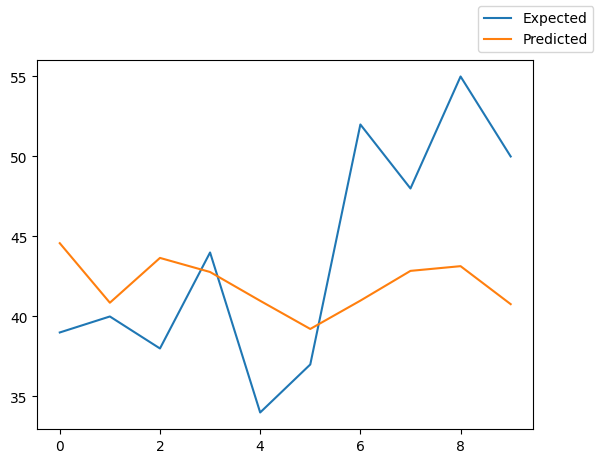

In [44]:
wfv.plot()

MAE:5.423193315914295, Window Width:1
MAE:5.429999999999999, Window Width:5
MAE:5.649166666666667, Window Width:10
MAE:5.3373333333333335, Window Width:30


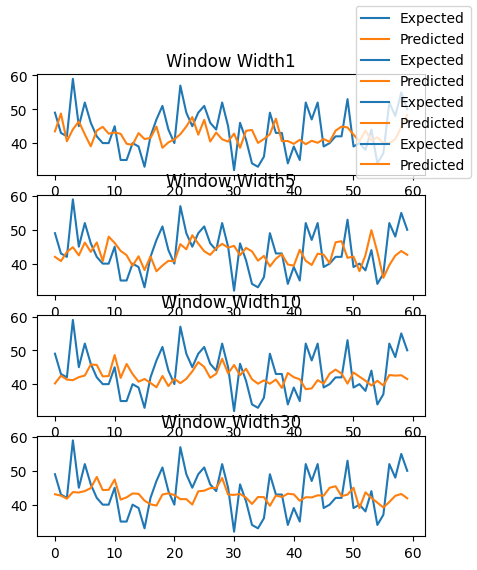

In [48]:
# Test 1 : default criterion
window_width = [1, 5, 10, 30]
fig, axes = plt.subplots(4, 1, figsize=(5, 6))
for idx, ww in enumerate(window_width):
    series_to_supervised = SeriesToSupervised(n_in=ww)
    births_supervised = series_to_supervised.fit_transform(births_ts_lst)
    features, labels = series_to_supervised.get_feature_label()
    random_forest_regressor = RandomForestRegressor()
    wfv = WalkForwardValidation(random_forest_regressor, features, labels, n_test=60)
    wfv.validate()
    print("MAE:{}, Window Width:{}".format(wfv.mae, ww))
    axes[idx].plot(wfv.expected, label="Expected")
    axes[idx].plot(wfv.predicted, label="Predicted")
    axes[idx].title.set_text("Window Width{}".format(ww))
    
fig.legend()



MAE:5.3445, Window Width:1
MAE:5.184166666666666, Window Width:5
MAE:5.349833333333334, Window Width:10
MAE:5.3782499999999995, Window Width:30


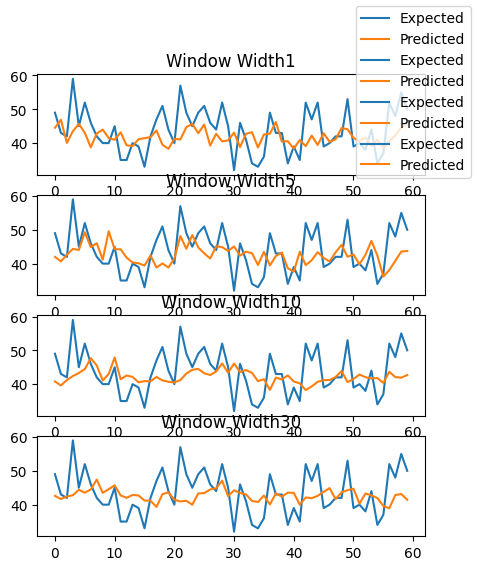

In [47]:
# Test 2 : criterion = 'absolute_error'

window_width = [1, 5, 10, 30]
fig, axes = plt.subplots(4, 1, figsize=(5, 6))
for idx, ww in enumerate(window_width):
    series_to_supervised = SeriesToSupervised(n_in=ww)
    births_supervised = series_to_supervised.fit_transform(births_ts_lst)
    features, labels = series_to_supervised.get_feature_label()
    random_forest_regressor = RandomForestRegressor(criterion='absolute_error')
    wfv = WalkForwardValidation(random_forest_regressor, features, labels, n_test=60)
    wfv.validate()
    print("MAE:{}, Window Width:{}".format(wfv.mae, ww))
    axes[idx].plot(wfv.expected, label="Expected")
    axes[idx].plot(wfv.predicted, label="Predicted")
    axes[idx].title.set_text("Window Width{}".format(ww))
    
fig.legend()


MAE:5.490933535055961, Window Width:1
MAE:6.0768, Window Width:5
MAE:5.940399999999999, Window Width:10
MAE:5.966399999999999, Window Width:30


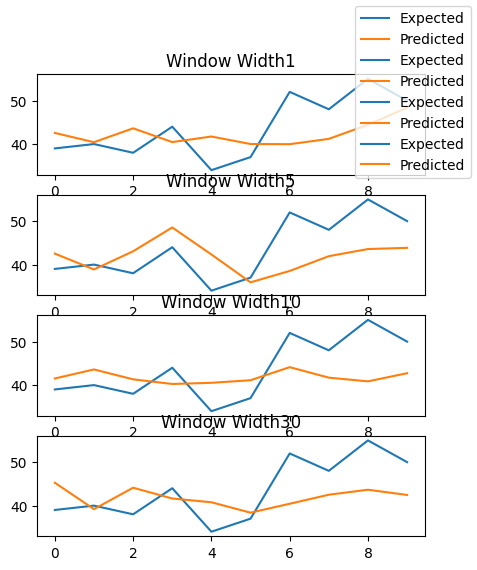

In [10]:
window_width = [1, 5, 10, 30]
fig, axes = plt.subplots(4, 1, figsize=(5, 6))
for idx, ww in enumerate(window_width):
    series_to_supervised = SeriesToSupervised(n_in=ww)
    births_supervised = series_to_supervised.fit_transform(births_ts_lst)
    features, labels = series_to_supervised.get_feature_label()
    random_forest_regressor = RandomForestRegressor(n_estimators=500)
    wfv = WalkForwardValidation(random_forest_regressor, features, labels, n_test=10)
    wfv.validate()
    print("MAE:{}, Window Width:{}".format(wfv.mae, ww))
    axes[idx].plot(wfv.expected, label="Expected")
    axes[idx].plot(wfv.predicted, label="Predicted")
    axes[idx].title.set_text("Window Width{}".format(ww))
    
fig.legend()


MAE:5.422205153324242, Window Width:1
MAE:5.993200000000001, Window Width:5
MAE:6.031599999999999, Window Width:10
MAE:5.803500000000001, Window Width:30


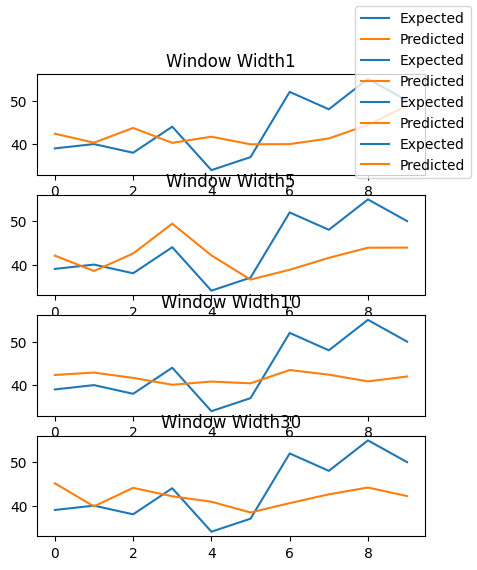

In [11]:
window_width = [1, 5, 10, 30]
fig, axes = plt.subplots(4, 1, figsize=(5, 6))
for idx, ww in enumerate(window_width):
    series_to_supervised = SeriesToSupervised(n_in=ww)
    births_supervised = series_to_supervised.fit_transform(births_ts_lst)
    features, labels = series_to_supervised.get_feature_label()
    random_forest_regressor = RandomForestRegressor(n_estimators=1000, criterion='absolute_error')
    wfv = WalkForwardValidation(random_forest_regressor, features, labels, n_test=10)
    wfv.validate()
    print("MAE:{}, Window Width:{}".format(wfv.mae, ww))
    axes[idx].plot(wfv.expected, label="Expected")
    axes[idx].plot(wfv.predicted, label="Predicted")
    axes[idx].title.set_text("Window Width{}".format(ww))
    
fig.legend()
